# **Model Evaluation: Domain-Specific Transfer Learning**
In this study, we explored the efficacy of transferring a pre-trained model to a new domain, specifically targeting bird species classification. The model was initially trained on a dataset comprised of a diverse range of bird species, representing a broad domain of avian imagery. This training was performed to leverage generalizable features learned from the extensive dataset.

For evaluation, the model was tested on a domain-specific dataset, which includes a curated selection of bird species relevant to a particular ecological region. The primary metrics used to assess performance were accuracy, precision, recall, F1 score, and confusion matrix.

# **Importing the required libraries**

In [ ]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import torch.nn as nn
from fuzzywuzzy import process
import warnings
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
from google.colab import drive
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Mounted at /content/drive


In [ ]:
#!pip install fuzzywuzzy

# **Define Data Transformation and Load Dataset**

In [ ]:
test_dir = "/content/drive/MyDrive/archive_birds_data/train"

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("Class names:", test_dataset.classes)

Class names: ['AMERICAN_GOLDFINCH', 'AMERICAN_PIPIT', 'AMERICAN_REDSTART', 'ANNAS_HUMMINGBIRD', 'BALTIMORE_ORIOLE', 'BARN_SWALLOW', 'BAY-BREASTED_WARBLER', 'BELTED_KINGFISHER', 'BLACK-THROATED_SPARROW', 'BLUE_GROSBEAK', 'BOBOLINK', 'BRANDT_CORMARANT', 'BREWERS_BLACKBIRD', 'BROWN_CREPPER', 'BROWN_THRASHER', 'CACTUS_WREN', 'CALIFORNIA_GULL', 'CAPE_GLOSSY_STARLING', 'CAPE_MAY_WARBLER', 'CASPIAN_TERN', 'CEDAR_WAXWING', 'CERULEAN_WARBLER', 'CHIPPING_SPARROW', 'CLARKS_NUTCRACKER', 'DARK_EYED_JUNCO', 'DOWNY_WOODPECKER', 'EASTERN_TOWEE', 'EUROPEAN_GOLDFINCH', 'EVENING_GROSBEAK', 'FRIGATE', 'GRAY_CATBIRD', 'GRAY_KINGBIRD', 'GREEN_JAY', 'HOODED_MERGANSER', 'HORNED_LARK', 'HOUSE_SPARROW', 'INDIGO_BUNTING', 'IVORY_GULL', 'LAZULI_BUNTING', 'LOGGERHEAD_SHRIKE', 'MALLARD_DUCK', 'MANGROVE_CUCKOO', 'NORTHERN_FLICKER', 'NORTHERN_FULMAR', 'NORTHERN_MOCKINGBIRD', 'OVENBIRD', 'PAINTED_BUNTING', 'PARAKETT__AKULET', 'POMARINE_JAEGER', 'PURPLE_FINCH', 'RED_FACED_CORMORANT', 'RED_HEADED_WOODPECKER', 'RED_WINGE

# **Define Class Mapping and Custom Dataset**
In our project, we aim to generalize our model trained on the CUB-200-2011 dataset by testing it on the Birds-525-Species classification dataset. Given the differences between these two datasets, it is essential to ensure consistency in class names and class IDs across both datasets. This alignment is crucial for accurate classification and evaluation. Therefore, we implemented a mapping process to standardize the class names and IDs in the testing dataset to match those of the training dataset. This harmonization allows our model to correctly interpret and classify the test data, facilitating a reliable assessment of its generalization capabilities.

In [ ]:
# Lists of training class IDs
training_class_names = [
    'Parakeet_Auklet', 'Brewer_Blackbird', 'Red_winged_Blackbird', 'Yellow_headed_Blackbird',
    'Bobolink', 'Indigo_Bunting', 'Lazuli_Bunting', 'Painted_Bunting', 'Spotted_Catbird',
    'Gray_Catbird', 'Yellow_breasted_Chat', 'Eastern_Towhee', 'Brandt_Cormorant',
    'Red_faced_Cormorant', 'Brown_Creeper', 'Mangrove_Cuckoo', 'Purple_Finch',
    'Northern_Flicker', 'Vermilion_Flycatcher', 'Frigatebird', 'Northern_Fulmar',
    'American_Goldfinch', 'European_Goldfinch', 'Blue_Grosbeak', 'Evening_Grosbeak',
    'Rose_breasted_Grosbeak', 'California_Gull', 'Ivory_Gull', 'Anna_Hummingbird',
    'Ruby_throated_Hummingbird', 'Pomarine_Jaeger', 'Green_Jay', 'Dark_eyed_Junco',
    'Tropical_Kingbird', 'Gray_Kingbird', 'Belted_Kingfisher', 'Horned_Lark', 'Mallard',
    'Hooded_Merganser', 'Mockingbird', 'Clark_Nutcracker', 'Baltimore_Oriole', 'Ovenbird',
    'American_Pipit', 'White_necked_Raven', 'American_Redstart', 'Loggerhead_Shrike',
    'Black_throated_Sparrow', 'Chipping_Sparrow', 'House_Sparrow', 'Cape_Glossy_Starling',
    'Barn_Swallow', 'Tree_Swallow', 'Scarlet_Tanager', 'Caspian_Tern', 'Brown_Thrasher',
    'Bay_breasted_Warbler', 'Cape_May_Warbler', 'Cerulean_Warbler', 'Cedar_Waxwing',
    'Red_headed_Woodpecker', 'Downy_Woodpecker', 'Cactus_Wren'
]

consistent_classes = {}
for test_id in test_dataset.classes:
    closest_match, _ = process.extractOne(test_id, training_class_names)
    consistent_classes[test_id] = closest_match
print(consistent_classes)

{'AMERICAN_GOLDFINCH': 'American_Goldfinch', 'AMERICAN_PIPIT': 'American_Pipit', 'AMERICAN_REDSTART': 'American_Redstart', 'ANNAS_HUMMINGBIRD': 'Anna_Hummingbird', 'BALTIMORE_ORIOLE': 'Baltimore_Oriole', 'BARN_SWALLOW': 'Barn_Swallow', 'BAY-BREASTED_WARBLER': 'Bay_breasted_Warbler', 'BELTED_KINGFISHER': 'Belted_Kingfisher', 'BLACK-THROATED_SPARROW': 'Black_throated_Sparrow', 'BLUE_GROSBEAK': 'Blue_Grosbeak', 'BOBOLINK': 'Bobolink', 'BRANDT_CORMARANT': 'Brandt_Cormorant', 'BREWERS_BLACKBIRD': 'Brewer_Blackbird', 'BROWN_CREPPER': 'Brown_Creeper', 'BROWN_THRASHER': 'Brown_Thrasher', 'CACTUS_WREN': 'Cactus_Wren', 'CALIFORNIA_GULL': 'California_Gull', 'CAPE_GLOSSY_STARLING': 'Cape_Glossy_Starling', 'CAPE_MAY_WARBLER': 'Cape_May_Warbler', 'CASPIAN_TERN': 'Caspian_Tern', 'CEDAR_WAXWING': 'Cedar_Waxwing', 'CERULEAN_WARBLER': 'Cerulean_Warbler', 'CHIPPING_SPARROW': 'Chipping_Sparrow', 'CLARKS_NUTCRACKER': 'Clark_Nutcracker', 'DARK_EYED_JUNCO': 'Dark_eyed_Junco', 'DOWNY_WOODPECKER': 'Downy_Woodp

# **Define and Use Custom ImageFolder Class**

In [ ]:
desired_class_to_idx = {
    'AMERICAN_GOLDFINCH': 21, 'AMERICAN_PIPIT': 43, 'AMERICAN_REDSTART': 45,
    'ANNAS_HUMMINGBIRD': 28, 'BALTIMORE_ORIOLE': 41, 'BARN_SWALLOW': 51,
    'BAY-BREASTED_WARBLER': 56, 'BELTED_KINGFISHER': 35, 'BLACK-THROATED_SPARROW': 47,
    'BLUE_GROSBEAK': 23, 'BOBOLINK': 4, 'BRANDT_CORMARANT': 12,
    'BREWERS_BLACKBIRD': 1, 'BROWN_CREPPER': 14, 'BROWN_THRASHER': 55,
    'CACTUS_WREN': 62, 'CALIFORNIA_GULL': 26, 'CAPE_GLOSSY_STARLING': 50,
    'CAPE_MAY_WARBLER': 57, 'CASPIAN_TERN': 54, 'CEDAR_WAXWING': 59,
    'CERULEAN_WARBLER': 58, 'CHIPPING_SPARROW': 48, 'CLARKS_NUTCRACKER': 40,
    'DARK_EYED_JUNCO': 32, 'DOWNY_WOODPECKER': 61, 'EASTERN_TOWEE': 11,
    'EUROPEAN_GOLDFINCH': 22, 'EVENING_GROSBEAK': 24, 'FRIGATE': 19,
    'GRAY_CATBIRD': 9, 'GRAY_KINGBIRD': 34, 'GREEN_JAY': 31,
    'HOODED_MERGANSER': 38, 'HORNED_LARK': 36, 'HOUSE_SPARROW': 49,
    'INDIGO_BUNTING': 5, 'IVORY_GULL': 27, 'LAZULI_BUNTING': 6,
    'LOGGERHEAD_SHRIKE': 46, 'MALLARD_DUCK': 37, 'MANGROVE_CUCKOO': 15,
    'NORTHERN_FLICKER': 17, 'NORTHERN_FULMAR': 20, 'NORTHERN_MOCKINGBIRD': 39,
    'OVENBIRD': 42, 'PAINTED_BUNTING': 7, 'PARAKETT__AKULET': 0,
    'POMARINE_JAEGER': 30, 'PURPLE_FINCH': 16, 'RED_FACED_CORMORANT': 13,
    'RED_HEADED_WOODPECKER': 60, 'RED_WINGED_BLACKBIRD': 2, 'ROSE_BREASTED_GROSBEAK': 25,
    'RUBY_THROATED_HUMMINGBIRD': 29, 'SCARLET_TANAGER': 53, 'SPOTTED_CATBIRD': 8,
    'TREE_SWALLOW': 52, 'TROPICAL_KINGBIRD': 33, 'VERMILION_FLYCATHER': 18,
    'WHITE_NECKED_RAVEN': 44, 'YELLOW_BREASTED_CHAT': 10, 'YELLOW_HEADED_BLACKBIRD': 3
}

class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform, target_transform=target_transform)
        original_classes = self.classes
        new_classes = [consistent_classes.get(cls, cls) for cls in original_classes]
        self.class_to_idx = {new_classes[i]: desired_class_to_idx[original_classes[i]] for i in range(len(original_classes))}
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        self.samples = [(path, self.class_to_idx[new_classes[target]]) for path, target in self.samples]
        self.targets = [self.class_to_idx[new_classes[target]] for target in self.targets]
        self.classes = new_classes

test_dataset = CustomImageFolder(root=test_dir, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)
print("Class names:", test_dataset.classes)

Class names: ['American_Goldfinch', 'American_Pipit', 'American_Redstart', 'Anna_Hummingbird', 'Baltimore_Oriole', 'Barn_Swallow', 'Bay_breasted_Warbler', 'Belted_Kingfisher', 'Black_throated_Sparrow', 'Blue_Grosbeak', 'Bobolink', 'Brandt_Cormorant', 'Brewer_Blackbird', 'Brown_Creeper', 'Brown_Thrasher', 'Cactus_Wren', 'California_Gull', 'Cape_Glossy_Starling', 'Cape_May_Warbler', 'Caspian_Tern', 'Cedar_Waxwing', 'Cerulean_Warbler', 'Chipping_Sparrow', 'Clark_Nutcracker', 'Dark_eyed_Junco', 'Downy_Woodpecker', 'Eastern_Towhee', 'European_Goldfinch', 'Evening_Grosbeak', 'Frigatebird', 'Gray_Catbird', 'Gray_Kingbird', 'Green_Jay', 'Hooded_Merganser', 'Horned_Lark', 'House_Sparrow', 'Indigo_Bunting', 'Ivory_Gull', 'Lazuli_Bunting', 'Loggerhead_Shrike', 'Mallard', 'Mangrove_Cuckoo', 'Northern_Flicker', 'Northern_Fulmar', 'Mockingbird', 'Ovenbird', 'Painted_Bunting', 'Parakeet_Auklet', 'Pomarine_Jaeger', 'Purple_Finch', 'Red_faced_Cormorant', 'Red_headed_Woodpecker', 'Red_winged_Blackbird',

# **Information about Dataset**

In [ ]:
img, label = test_dataset[0]
img_shape = img.shape
print(f"Shape of the image tensor: {img_shape}")

print("Max & Min Pixel Values:", "Max:", torch.max(img), "Min:", torch.min(img))
print('Number of samples in test set: ', len(test_dataset))
print("No. of batches in Testing dataset: ", len(test_loader))

Shape of the image tensor: torch.Size([3, 224, 224])
Max & Min Pixel Values: Max: tensor(2.3761) Min: tensor(-2.0152)
Number of samples in test set:  9973
No. of batches in Testing dataset:  156


# **Visualization**

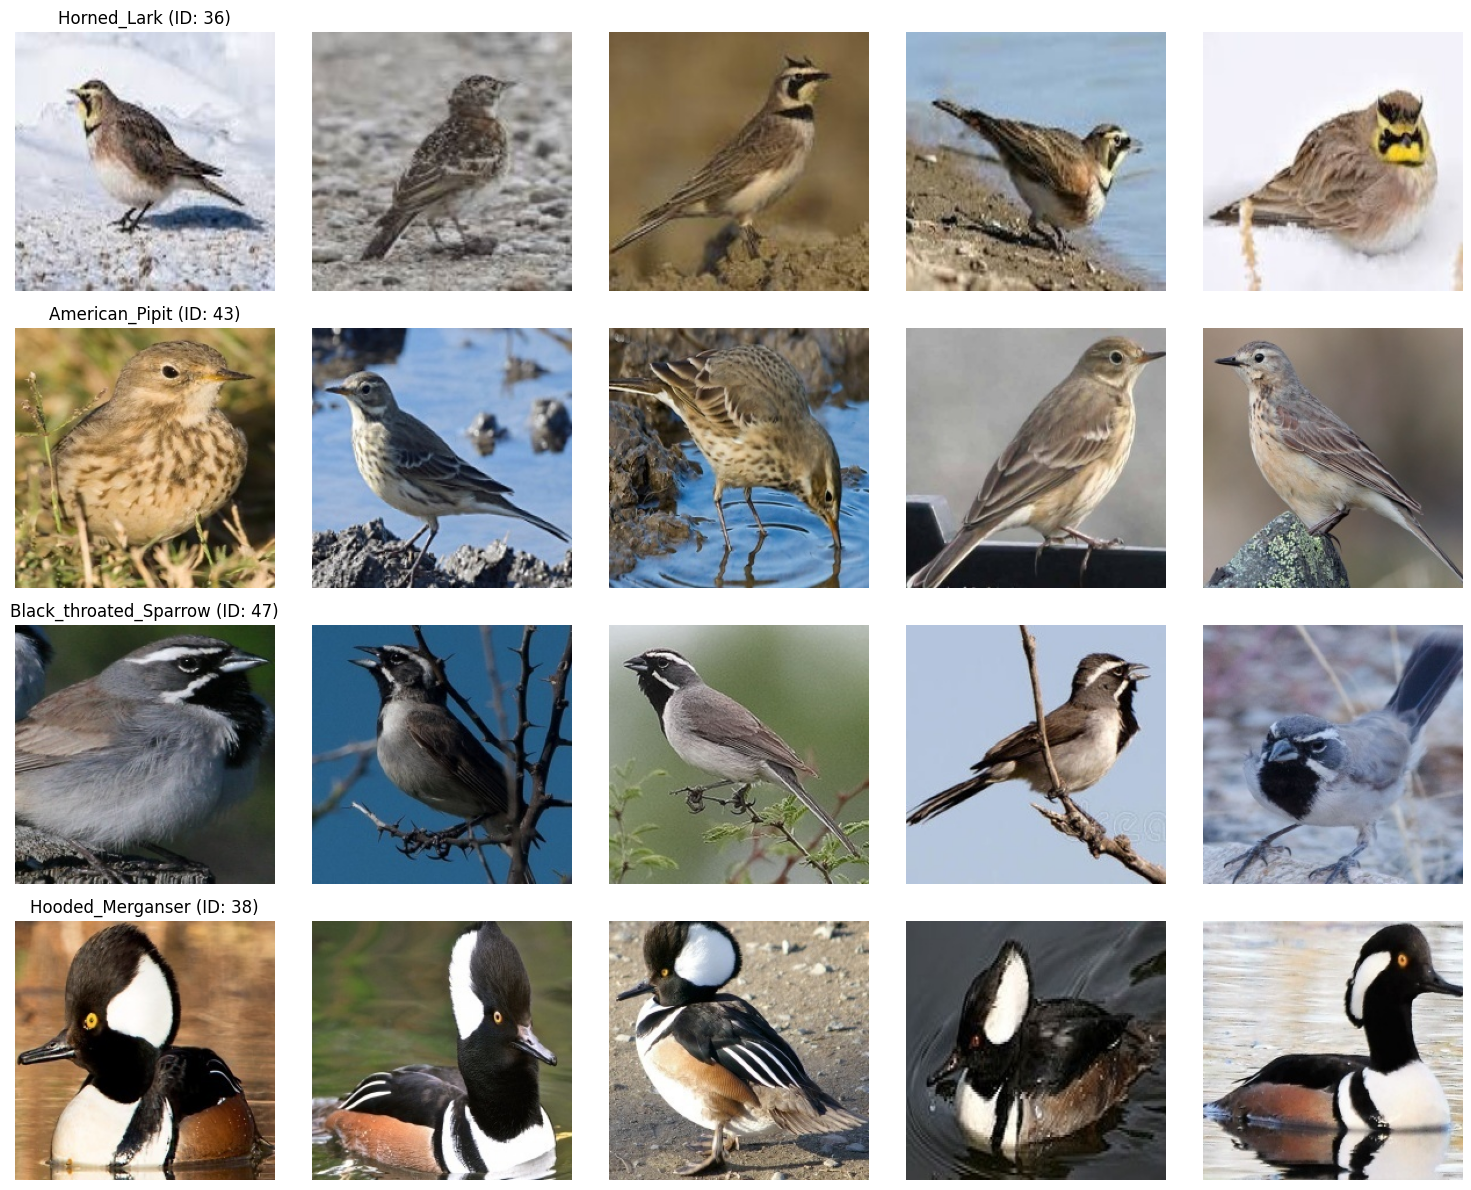

In [ ]:
def get_random_classes(dataset, num_classes=4):
    classes = dataset.classes
    selected_classes = random.sample(classes, num_classes)
    return selected_classes

def get_images_for_class(dataset, class_name, num_images=5):
    class_idx = dataset.class_to_idx[class_name]
    class_images = [path for path, label in dataset.samples if label == class_idx]
    selected_images = random.sample(class_images, min(num_images, len(class_images)))
    return selected_images

def plot_images_for_classes(dataset, class_names, num_images_per_class=5):
    fig, axes = plt.subplots(len(class_names), num_images_per_class, figsize=(15, len(class_names)*3))

    for i, class_name in enumerate(class_names):
        class_id = dataset.class_to_idx[class_name]  # Get the class ID
        image_paths = get_images_for_class(dataset, class_name, num_images_per_class)

        for j, img_path in enumerate(image_paths):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f'{class_name} (ID: {class_id})')  # Include class ID in title

    plt.tight_layout()
    plt.show()
random_classes = get_random_classes(test_dataset, num_classes=4)
plot_images_for_classes(test_dataset, random_classes)

# **Load the Trained Model**

In [ ]:
model_path = "/content/resnet18_model.pth"
model = resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(test_dataset.classes))
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# **Test the Model**

In [ ]:
def test_model(model, test_loader):
    model.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test images: {accuracy:.2f}%')
    return accuracy
test_accuracy = test_model(model, test_loader)

Accuracy of the model on the test images: 84.32%


# **Precision, Recall, and F1-Score**

In [ ]:
def calculate_precision_recall_f1(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-Score: {f1:.2f}')

    return precision, recall, f1
precision, recall, f1 = calculate_precision_recall_f1(model, test_loader)

Precision: 0.86
Recall: 0.84
F1-Score: 0.84


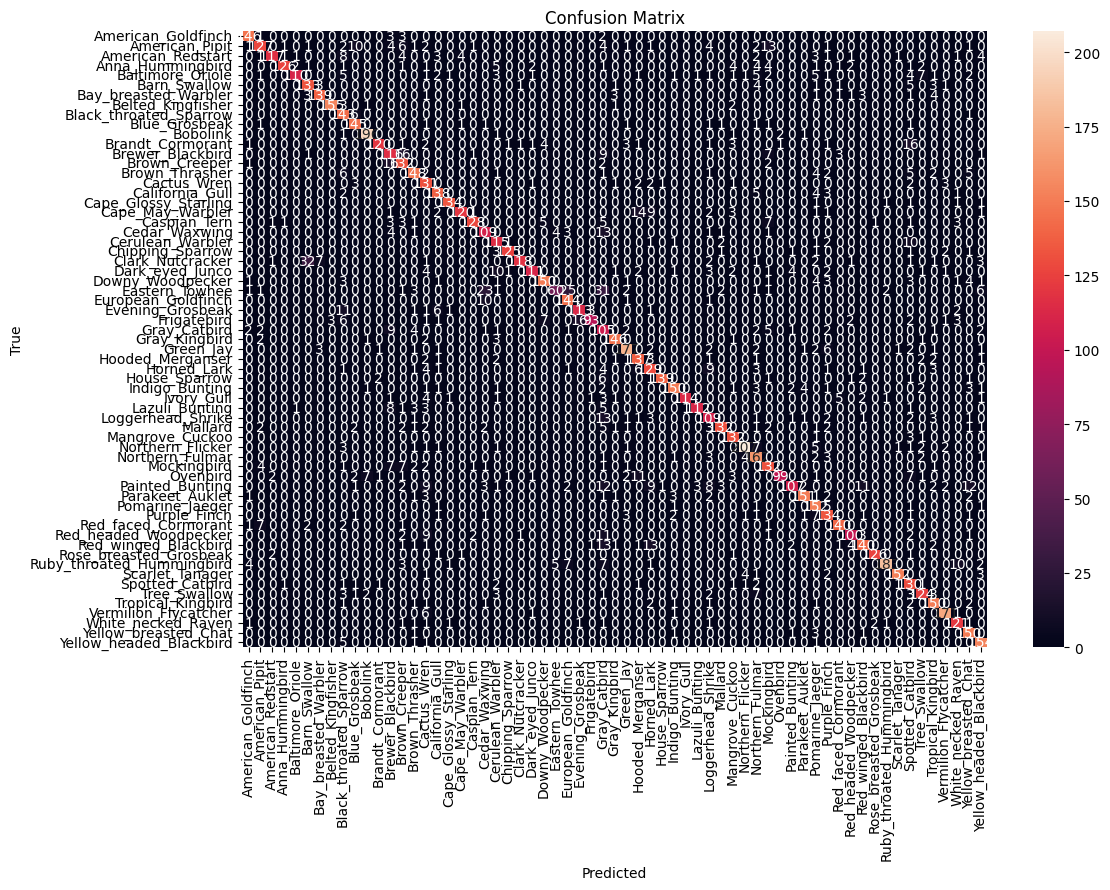

In [ ]:
def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Plot confusion matrix
plot_confusion_matrix(model, test_loader)

# **Summary**
All the metrics—accuracy, precision, recall, and F1-score—are in a good range, demonstrating that the model performs well in classifying bird species. The model is accurate, reliable, and balanced, showing strong potential for practical applications in bird species identification.

# **Conclusion**
In this project, we aimed to develop and evaluate a deep learning model for bird species classification using the CUB_200_2011 dataset. Our approach involved training a ResNet-18 model on the dataset and testing its performance on a diverse set of bird images. The model achieved an accuracy of 84.32%, demonstrating its effectiveness in distinguishing between various bird species.

The performance metrics, including precision, recall, and F1-score, further validate the model's robustness. With a precision of 0.86 and recall of 0.84, the model successfully minimizes false positives while ensuring comprehensive detection of relevant species. The F1-score of 0.84 highlights the balanced performance of the model, making it a reliable tool for bird classification tasks.

While the results are promising, there are areas for potential improvement. Future work could involve fine-tuning hyperparameters, exploring different architectures, or augmenting the dataset to enhance model performance further. Additionally, deploying the model in real-world scenarios could provide valuable insights into its practical utility and areas for refinement.

Overall, this project demonstrates the feasibility of using deep learning techniques for bird species classification and sets the stage for future advancements in this field. The successful implementation of the model underscores the potential of artificial intelligence in contributing to wildlife research and conservation efforts.